# **ML Modeling and Evaluation - Classification**

## Objectives

* Fit a feature engineering pipeline
* Fit a classification model to predict the health risk level of patients
* Evaluate the classification model performance
  
## Inputs

* Cleaned Maternal Health Risks dataset: outputs/cleaned/maternal-health-risk-dataset-clean.csv
* Instructions on feature engineering steps to take (see previous notebook)

## Outputs

* Train set (features and target)
* Test set (features and target)
* Feature engineering pipeline
* Modeling pipeline
* Feature importance plot

---

# Import Packages for Modelling and Evaluation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# feature engineering
from feature_engine import transformation as vt
from feature_engine.selection import SmartCorrelatedSelection

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# scaling
from sklearn.preprocessing import StandardScaler

# feauture selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# grid search
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, recall_score

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

# Change working directory

We need to change the working directory from its current folder to its parent folder
* Access current directory with os.getcwd()

In [ ]:
current_dir = os.getcwd()
current_dir

'/workspaces/ML-maternal-health-risk/jupyter_notebooks'

Make the parent of the current directory the new current directory, and confirm new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* os.getcwd() get the current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"New current directory set to {current_dir}.")

New current directory set to /workspaces/ML-maternal-health-risk.


# Step 1: Load Data

Recall that we can directly load the cleaned dataset, since the only data cleaning we had to do was to remove 3 (suspectedly) erronous datapoints. There were no steps that could be performed in a data cleaning pipeline.

In [4]:
df = pd.read_csv('outputs/datasets/cleaned/maternal-health-risk-dataset-clean.csv')
print(df.shape)
df.head()

(1011, 7)


,Age,SystolicBP,DiastolicBP,BloodSugar,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,36.7,86,2
1,35,140,90,13.0,36.7,70,2
2,29,90,70,8.0,37.8,80,2
3,30,140,85,7.0,36.7,70,2
4,35,120,60,6.1,36.7,76,0


---

# Step 2: ML pipeline with all Data

## ML Pipeline for Feature Engineering

In this section we will implement the ML pipeline for feature engineering. Recall that we do not need a DataCleaning Pipeline in this project due to an already clean dataset.

We implement a pipeline including the following steps:

* Numerical Transformations: Box-Cox transformation for `["Age", "SystolicBP", "BloodSugar"]`
* SmartCorrelatedSelection (which will drop `["DiastolicBP"]`)

Define the Featureengineering pipeline and call it

In [5]:
def PipelineFeatureEngineering():
    """
    Defines a pipeline including the feature engineering steps from above
    Box-Cox transformation
    SmartCorrelatedSelection
    """
    pipeline_base = Pipeline([
        ("BoxCoxTransformation", vt.BoxCoxTransformer(variables=[
                                                    "Age",
                                                    "SystolicBP",
                                                    "BloodSugar"
                                                    ])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(
                                        variables=None,
                                        method="spearman",
                                        threshold=0.6,
                                        selection_method="variance"
                                        )),
    ])

    return pipeline_base


PipelineFeatureEngineering()

Pipeline(steps=[('BoxCoxTransformation',
                 BoxCoxTransformer(variables=['Age', 'SystolicBP',
                                              'BloodSugar'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

## ML Pipeline for Modelling and Hyperparameter Optimization

Define a pipeline that handles the ML Classifier modelling. It also includes feature scaling and feature selection which both need to happen after the feature engineering step.
We choose the StandardScaler to scale our features and the SelectFromModel to select the most important features to train the model.

In [ ]:
def PipelineClassifier(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Next, we will conduct a hyperparameter optimization search to get the classification model as well as the hyperparameters that fit our dataset the best.

We start with a custom class for an efficient hyperparameter optimisation as well as algorithm search.

In [7]:
# The code for this class was taken from the Code Institute churnometer walkthrough project and adapted for this project


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClassifier(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


### Split into Train and Test Set

Before getting into the hyperparameter optimisation we need to split our dataset into train and test set

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['RiskLevel'], axis=1),
    df['RiskLevel'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 6) (808,) (203, 6) (203,)


### Fit Feature Engineering Pipeline to Train Set

In [9]:

# Create feature engineering pipeline
pipeline_feat_eng = PipelineFeatureEngineering()

# fit on the train set and transform train set
X_train = pipeline_feat_eng.fit_transform(X_train)
# transform the test set
X_test = pipeline_feat_eng.transform(X_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(808, 5) (808,) (203, 5) (203,)


### **Handle Target Imbalance**

As mentioned in the data collection notebook the RiskLevel target column is moderately imbalanced. To improve model performance we perform SMOTE (Synthetic Minority Oversamplin Technique) to balance the train set by creating synthetic data. Importantly, we do this after fitting the feature engineering pipeline.

Plot the target distribution from the train set:

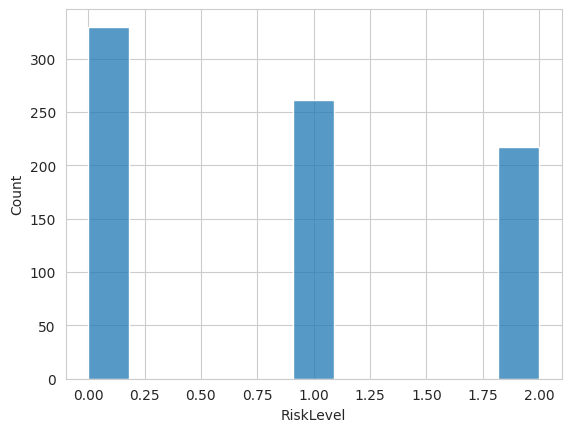

In [10]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

In [11]:
y_train.value_counts()

RiskLevel
0    330
1    261
2    217
Name: count, dtype: int64

**Resample the dataset with SMOTE**

The sample is slightly imbalanced with RiskLevel counts:
* low-risk (0): 330
* mid-risk (1): 261
* high-risk (2): 217

We decide to take a moderate oversampling approach of resampling both mid-risk and high-risk to 300. This is because, even though a totally balanced dataset might be advantageous for the classifier models, there is a risk of overfitting the models. Since our dataset is relatively small, generating too much synthetic high-risk data might overfit our model towards high-risk.

Fit and resample the test set:

In [12]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy={
                1: 300,
                2: 300
                }, 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(930, 5) (930,) (203, 5) (203,)


In [50]:
# Create SMOTE object

oversample = SMOTE(
                sampling_strategy="all", 
                random_state=0
                )

# fit oversample to train set and resample the train set
X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(990, 5) (990,) (203, 5) (203,)


Check the target distibution for the train set again after resampling. It is now more balanced but purposefully not completely balanced.

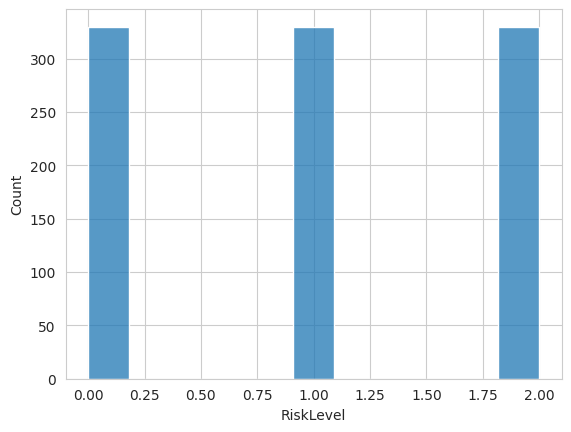

In [51]:
sns.set_style("whitegrid")
sns.histplot(data=y_train)
plt.show()

### Grid Search for hyperparameter optimisation

We use Grid Search CV to conduct a hypermarameter optimisation search. The first step is to focus on finding the most suitable algorithm before optimizing its hyperparameters.

So let us first search through many different classification algorithms using only their standard hyperparameters for efficiency. Next, we will choose the best algorithm and conduct an extensive hyperparameter optimisation search on this specific algorithm (or several good ones).

In [10]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "AdaBoostClassifier": {},
    "ExtraTreesClassifier": {},
    "GradientBoostingClassifier": {},
    "XGBClassifier": {},
}

We perform the grid search with the goal

In [11]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, labels=[2], average=None),
                # scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [12]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
3,AdaBoostClassifier,0.840909,0.875899,0.930233,0.033236
2,RandomForestClassifier,0.818182,0.857294,0.906977,0.029839
6,XGBClassifier,0.813953,0.834144,0.860465,0.016795
5,GradientBoostingClassifier,0.795455,0.820402,0.837209,0.015709
4,ExtraTreesClassifier,0.767442,0.811099,0.860465,0.030483
1,DecisionTreeClassifier,0.545455,0.742283,0.863636,0.109264
0,LogisticRegression,0.568182,0.738266,0.883721,0.10393


In [13]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(
                X_train,
                y_train,
                # scoring = make_scorer(recall_score, labels=[2], average=None),
                scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [14]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestClassifier,0.679012,0.794632,0.84472,0.059172
6,XGBClassifier,0.67284,0.720359,0.745342,0.027132
4,ExtraTreesClassifier,0.685185,0.712959,0.751553,0.02913
5,GradientBoostingClassifier,0.685185,0.707967,0.732919,0.017766
1,DecisionTreeClassifier,0.58642,0.686895,0.777778,0.071253
3,AdaBoostClassifier,0.641975,0.66465,0.68323,0.01721
0,LogisticRegression,0.540373,0.610145,0.677019,0.058639


take RandomForestClassifier, and XGBClassifier to next seasrch, still take Adaboost because of high high-risk recall scores

In [15]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "XGBClassifier":XGBClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "XGBClassifier":{
        'model__n_estimators': [30,80,200],
        'model__max_depth': [None, 3, 10, 15],
        'model__learning_rate': [0.01,0.1,0.001],
        'model__gamma': [0, 0.1],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
    },
    "RandomForestClassifier": {
        'model__n_estimators': [100,50,140],
        'model__max_depth': [None,4, 15],
        'model__min_samples_split': [2,50],
        'model__min_samples_leaf': [1,50],
        'model__max_leaf_nodes': [None,50],
    },
    "AdaBoostClassifier": {
        'model__n_estimators': [50,25,80,150],
        'model__learning_rate':[1,0.1, 2],
    }
}

In [16]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
                X_train,
                y_train,
                # scoring = make_scorer(recall_score, labels=[2], average=None),
                scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Look at averaged recall, since these very high max-scores for high-risk recall seem suspicious, might be biased towards high risk. 

---

In [19]:
grid_search_summary_ave, grid_search_pipelines_ave = search.score_summary(sort_by='mean_score')
grid_search_summary_ave 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__gamma,model__learning_rate
2,RandomForestClassifier,0.679012,0.795867,0.84472,0.059898,None,None,1,2,140,NaN,NaN
0,RandomForestClassifier,0.679012,0.794632,0.84472,0.059172,None,None,1,2,100,NaN,NaN
48,RandomForestClassifier,0.679012,0.794632,0.84472,0.059557,15,None,1,2,100,NaN,NaN
50,RandomForestClassifier,0.679012,0.794625,0.84472,0.059709,15,None,1,2,140,NaN,NaN
1,RandomForestClassifier,0.679012,0.792156,0.84472,0.059075,None,None,1,2,50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
100,XGBClassifier,0.641975,0.657174,0.691358,0.018204,3,NaN,NaN,NaN,80,0,0.001
151,AdaBoostClassifier,0.623457,0.65597,0.679012,0.021132,NaN,NaN,NaN,NaN,150,NaN,0.1
150,AdaBoostClassifier,0.592593,0.622598,0.664596,0.026663,NaN,NaN,NaN,NaN,80,NaN,0.1
148,AdaBoostClassifier,0.561728,0.600307,0.627329,0.023296,NaN,NaN,NaN,NaN,50,NaN,0.1


In [82]:
grid_search_summary.to_csv("outputs/datasets/grid_search_summary_temp.csv")

In [23]:
search_high_risk = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search_high_risk.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, labels=[2], average=None),
                # scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 72 candidates, totalling 360 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [26]:
grid_search_summary_high_risk, grid_search_pipelines_high_risk = search_high_risk.score_summary(sort_by='mean_score')
grid_search_summary_high_risk 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__gamma,model__learning_rate
146,AdaBoostClassifier,0.8,0.88,0.933333,0.04397,NaN,NaN,NaN,NaN,80,NaN,1
144,AdaBoostClassifier,0.8,0.88,0.933333,0.04397,NaN,NaN,NaN,NaN,50,NaN,1
145,AdaBoostClassifier,0.783333,0.876667,0.933333,0.050111,NaN,NaN,NaN,NaN,25,NaN,1
19,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,None,50,50,2,50,NaN,NaN
58,RandomForestClassifier,0.816667,0.87,0.933333,0.046428,15,None,50,50,50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
152,AdaBoostClassifier,0.666667,0.793333,0.866667,0.079303,NaN,NaN,NaN,NaN,50,NaN,2
153,AdaBoostClassifier,0.733333,0.793333,0.85,0.047842,NaN,NaN,NaN,NaN,25,NaN,2
150,AdaBoostClassifier,0.616667,0.766667,0.866667,0.094868,NaN,NaN,NaN,NaN,80,NaN,0.1
148,AdaBoostClassifier,0.633333,0.73,0.866667,0.092135,NaN,NaN,NaN,NaN,50,NaN,0.1


In [85]:
grid_search_summary.to_csv("outputs/datasets/grid_search_summary_high_risk_recall_temp.csv")

In [14]:
grid_search_summary_recall_ave = pd.read_csv("outputs/datasets/grid_search_summary_temp.csv")

In [20]:
grid_search_summary_recall_ave

NameError: name 'grid_search_summary_recall_ave' is not defined

In [15]:
grid_search_summary_recall_highrisk = pd.read_csv("outputs/datasets/grid_search_summary_high_risk_recall_temp.csv")

Continue with three models: randomforestclassifier which gives best results for averaged recall, adaboostclassifier and randomforestclassifier with best results for high risk recall. Want to see confusion matrix for all of them to come to a conclusion.

Get models programmatically:

In [21]:
best_model_ave = grid_search_summary_ave.iloc[0,0]
best_model_ave

'RandomForestClassifier'

In [32]:
best_model_hr_ada = grid_search_summary_high_risk.iloc[0,0]
best_model_hr_ada

'AdaBoostClassifier'

In [39]:
best_model_hr_rf = grid_search_summary_high_risk.iloc[3,0]
best_model_hr_rf

'RandomForestClassifier'

In [22]:

best_parameters_ave = grid_search_pipelines_ave[best_model_ave].best_params_
best_parameters_ave

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 140}

In [33]:
best_parameters_hr_ada = grid_search_pipelines_high_risk[best_model_hr_ada].best_params_
best_parameters_hr_ada

{'model__learning_rate': 1, 'model__n_estimators': 50}

In [40]:
best_parameters_hr_rf = grid_search_pipelines_high_risk[best_model_hr_rf].best_params_
best_parameters_hr_rf

{'model__max_depth': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Define the best clf pipeline (optimized for recall averaged over the three classes).

In [23]:
pipeline_clf_ave = grid_search_pipelines_ave[best_model_ave].best_estimator_
pipeline_clf_ave

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(n_estimators=140, random_state=0))])

In [34]:
pipeline_clf_hr_ada = grid_search_pipelines_high_risk[best_model_hr_ada].best_estimator_
pipeline_clf_hr_ada

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=AdaBoostClassifier(random_state=0))),
                ('model', AdaBoostClassifier(learning_rate=1, random_state=0))])

In [41]:
pipeline_clf_hr_rf = grid_search_pipelines_high_risk[best_model_hr_rf].best_estimator_
pipeline_clf_hr_rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=50,
                                        random_state=0))])

### Evalueate Pipelines on Train and Test Sets

We evaluate the three classifier pipelines on the train and the test set to decide which one is best suitable for our project.

In [24]:
def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


Metrics defined in the business case:
* Recall for high-risk should be at least 70% (due to small dataset) but ideally over 80%

Test RandomForestClassifier optimized for averaged recall:

In [25]:

clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_ave,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              294              17                3
Prediction mid risk               32             237               13
Prediction high risk               4               7              201


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.94      0.89      0.91       330
    mid risk       0.84      0.91      0.87       261
   high risk       0.95      0.93      0.94       217

    accuracy                           0.91       808
   macro avg       0.91      0.91      0.91       808
weighted avg       0.91      0.91      0.91       808
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               61              15                1
Prediction mid risk               10              59               

Evaluate AdaBoost classifier which gives best results for recall on high risk but decreased performance is expected on other classes.

We will check whether the trade off is worth it or too much to accept.

In [35]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_hr_ada,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              247             110               30
Prediction mid risk               80             132                4
Prediction high risk               3              58              266


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.64      0.75      0.69       330
    mid risk       0.61      0.44      0.51       300
   high risk       0.81      0.89      0.85       300

    accuracy                           0.69       930
   macro avg       0.69      0.69      0.68       930
weighted avg       0.69      0.69      0.68       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               55              28                6
Prediction mid risk               17              39               

Evaluate Random Forest classifier which gives results almost as good for recall on high risk and is expected to give better performance on other classes compared to AdaBoost.

In [42]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_hr_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              248             113               28
Prediction mid risk               76             125                6
Prediction high risk               6              62              266


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.64      0.75      0.69       330
    mid risk       0.60      0.42      0.49       300
   high risk       0.80      0.89      0.84       300

    accuracy                           0.69       930
   macro avg       0.68      0.68      0.67       930
weighted avg       0.68      0.69      0.67       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               56              33                5
Prediction mid risk               15              34               

We see that the performance of the RandomForestClassifier that was optimized for averaged recall is better than the models optimized on high risk recall. The latter two only have slightly better high-risk recall, while the other metrics (especially for predicting mid risk) are generally worse. Note also that the first model has better presicion in predicting low risk which is very important in medical predicitons as one wants to avoid classifying a patient as low risk when they in fact are higher risk.

However, it in the best model we note that the performance on the test set is wors then in the train set. Most notably the recall for high-risk class goes from 88% to 78%, that is a drop in 10 percentage points. Since our dataset is relatively small, it could be acceptable, but it is a notable difference and needs further investigation since it could be a hint of some overfitting happening.

We will investigate the random forest model further and conduct another grid search with more hyperparameters trying to avoid overfitting.

In [54]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0)
}

params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [100, 140, 200],
        'model__max_depth': [3, 6, 8, 10, 15],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5],
        'model__max_leaf_nodes': [None]
    }
}

In [55]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(
                X_train,
                y_train,
                scoring = make_scorer(recall_score, average="weighted"),
                n_jobs=-1,
                cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 135 candidates, totalling 675 fits


Look at averaged recall, since these very high max-scores for high-risk recall seem suspicious, might be biased towards high risk. 

---

Note the parameters we had before were: 

{'model__max_depth': 15,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

 Since we suspect slight overfitting we try an include only max_depth values below 10 and see whether another one might be a better fit for the test data. 

In [43]:
grid_search_summary_ave_rf, grid_search_pipelines_ave_rf = search.score_summary(sort_by='mean_score')
grid_search_summary_ave_rf 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
29,RandomForestClassifier,0.691358,0.730274,0.770186,0.028213,6,None,1,2,200
32,RandomForestClassifier,0.685185,0.724078,0.770186,0.028007,6,None,1,5,200
28,RandomForestClassifier,0.691358,0.724063,0.763975,0.023397,6,None,1,2,140
27,RandomForestClassifier,0.691358,0.722836,0.763975,0.024491,6,None,1,2,100
35,RandomForestClassifier,0.697531,0.720344,0.763975,0.022754,6,None,1,10,200
30,RandomForestClassifier,0.685185,0.717882,0.763975,0.025802,6,None,1,5,100
33,RandomForestClassifier,0.691358,0.717859,0.763975,0.02517,6,None,1,10,100
31,RandomForestClassifier,0.685185,0.71664,0.757764,0.023609,6,None,1,5,140
34,RandomForestClassifier,0.697531,0.716617,0.751553,0.018458,6,None,1,10,140
44,RandomForestClassifier,0.697531,0.71539,0.751553,0.018947,6,None,2,10,200


In [44]:
best_model_ave_rf = grid_search_summary_ave_rf.iloc[0,0]
best_model_ave_rf

'RandomForestClassifier'

In [45]:

best_parameters_ave_rf = grid_search_pipelines_ave_rf[best_model_ave_rf].best_params_
best_parameters_ave_rf

{'model__max_depth': 6,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 200}

In [46]:

pipeline_clf_rf = grid_search_pipelines_ave_rf[best_model_ave_rf].best_estimator_
pipeline_clf_rf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=6, n_estimators=200,
                                        random_state=0))])

In [47]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              302              93               25
Prediction mid risk               25             148                7
Prediction high risk               3              20              185


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.72      0.92      0.81       330
    mid risk       0.82      0.57      0.67       261
   high risk       0.89      0.85      0.87       217

    accuracy                           0.79       808
   macro avg       0.81      0.78      0.78       808
weighted avg       0.80      0.79      0.78       808
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               64              35                6
Prediction mid risk                8              36               

In [40]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              299              69               22
Prediction mid risk               28             184               17
Prediction high risk               3               8              178


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.77      0.91      0.83       330
    mid risk       0.80      0.70      0.75       261
   high risk       0.94      0.82      0.88       217

    accuracy                           0.82       808
   macro avg       0.84      0.81      0.82       808
weighted avg       0.83      0.82      0.82       808
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               64              22                5
Prediction mid risk                8              51               

In [136]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_rf,
                label_map= ['low risk', 'mid risk', 'high risk'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk              248              60               19
Prediction mid risk               78             221               22
Prediction high risk               4              19              259


---  Classification Report  ---
              precision    recall  f1-score   support

    low risk       0.76      0.75      0.75       330
    mid risk       0.69      0.74      0.71       300
   high risk       0.92      0.86      0.89       300

    accuracy                           0.78       930
   macro avg       0.79      0.78      0.79       930
weighted avg       0.79      0.78      0.78       930
 

#### Test Set ####

---  Confusion Matrix  ---
                     Actual low risk Actual mid risk Actual high risk
Prediction low risk               52              20                4
Prediction mid risk               19              52               

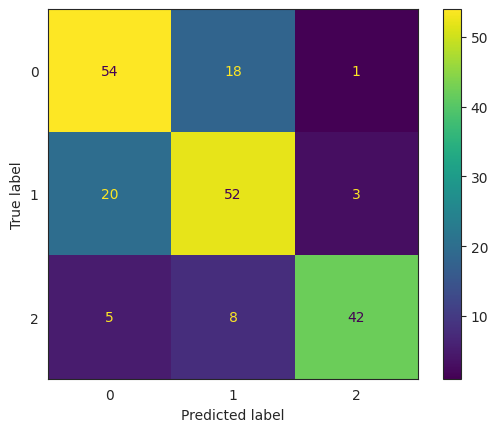

In [ ]:
sns.set_style("white")

predictions = pipeline_clf_rf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=pipeline_clf_rf.classes_)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low risk", "mid risk", "high risk "])
disp.plot()
plt.show()

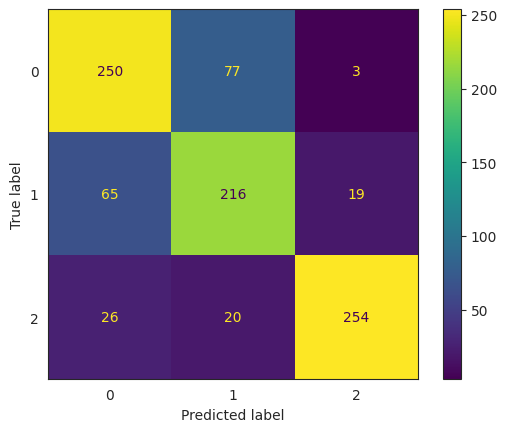

In [115]:
predictions = pipeline_clf_rf.predict(X_train)
cm = confusion_matrix(y_train, predictions, labels=pipeline_clf_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_clf_rf.classes_)
disp.plot()
plt.show()

# Conclusions